In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_clust_cos_glm import Sub_Clust_Cos_GLM
from models.clust_gru import Clust_GRU

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep600_stimseed4.npy"
V_file = "V_diff_stimseed4.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep600_stimseed4.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep600_stimseed4.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

print(e_idx.shape)
print(i_idx.shape)

torch.Size([330])
torch.Size([8])


In [3]:
T_train = 580 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 4
#E_no = 2000
#I_no = 200
E_no = e_idx.shape[0]
I_no = i_idx.shape[0]
T_no = 500
device = torch.device("cuda")

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 5800*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
#V_test = V[-50000:].to(device).float()
V_test = V[T_train:T_train+T_test].to(device).float()

#test_E_neural = E_neural[-50000:].toarray()
#test_I_neural = I_neural[-50000:].toarray()
test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

# Train

In [5]:
model = Sub_Clust_Cos_GLM(sub_no, E_no, I_no, T_no, H_no, device)
#model = Clust_GRU(sub_no, E_no, I_no, H_no, device)

syn_params = []
rest_params = []

for name, params in model.named_parameters():
    if (name == "C_syn_e_raw"):
        syn_params.append(params)
    elif (name == "C_syn_i_raw"):
        syn_params.append(params)
    else:
        rest_params.append(params)

# GLM
optimizer = torch.optim.Adam(rest_params, lr = 0.005/(1.03**100))
syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005/(1.03**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.03)
syn_milestones = np.arange(increment-1, increment*100, increment)
syn_scheduler = torch.optim.lr_scheduler.MultiStepLR(syn_optimizer, milestones=syn_milestones, gamma=1.03)

# GRU
#optimizer = torch.optim.Adam(rest_params, lr = 0.005)
#syn_optimizer = torch.optim.Adam(syn_params, lr = 0.005/(1.03**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)
#syn_milestones = np.arange(increment-1, increment*100, increment)
#syn_scheduler = torch.optim.lr_scheduler.MultiStepLR(syn_optimizer, milestones=syn_milestones, gamma=1.03)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

print(sum(p.numel() for p in syn_params if p.requires_grad))
print(sum(p.numel() for p in rest_params if p.requires_grad))
print(milestones.shape)

2187
1352
835
(100,)


In [ ]:
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

score_list = []
temp_list = np.logspace(0,-3,100)
temp_count = 0

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    syn_optimizer.zero_grad()
           
    with torch.no_grad():
        model.C_syn_e_raw.copy_(model.C_syn_e_raw - torch.mean(model.C_syn_e_raw, 0).reshape(1,-1))
        model.C_syn_i_raw.copy_(model.C_syn_i_raw - torch.mean(model.C_syn_i_raw, 0).reshape(1,-1))
    
    if (temp_count < 99) & (i%increment == increment-1):
        temp_count += 1
    temp = torch.tensor([temp_list[temp_count]]).to(device).float()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    #V_pred, _, C_syn_e, C_syn_i  = model(batch_E_neural, batch_I_neural, temp, True)
    V_pred, _, C_syn_e, C_syn_i  = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx], temp, True)
    
    loss = torch.mean((V_pred - batch_V[:,5000:35000])**2)
    #loss = torch.mean((V_pred - batch_V[:,:])**2)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    syn_optimizer.step()
    syn_scheduler.step()
    grad_size = torch.mean(torch.abs(model.C_syn_e_raw.grad)).item()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        #test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0), 0.0001, True)
        test_V_pred, test_sub_out, test_C_syn_e, test_C_syn_i = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx], 0.0001, True)
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[5000:35000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        train_score = explained_variance_score(batch_V[0,5000:35000].cpu().detach().numpy(), V_pred[0].cpu().detach().numpy())
        #test_score = explained_variance_score(V_test[:].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        #train_score = explained_variance_score(batch_V[0].cpu().detach().numpy(), V_pred[0].cpu().detach().numpy())
        score_list.append(test_score)
        
        #C_syn_idx = torch.argmax(test_C_syn_e[:,880:1120], 0).float()
        #C_syn_idx = torch.argmax(test_C_syn_e[:,29:269], 0).float()
        C_syn_idx = torch.argmax(test_C_syn_e[:,43:283], 0).float()
        
        mode1, mode1_idx = torch.mode(C_syn_idx[:60])
        mode2, mode2_idx = torch.mode(C_syn_idx[60:120])
        mode3, mode3_idx = torch.mode(C_syn_idx[120:180])
        mode4, mode4_idx = torch.mode(C_syn_idx[180:240])
        mode1_no = torch.numel(torch.where(C_syn_idx[:60] == mode1)[0])
        mode2_no = torch.numel(torch.where(C_syn_idx[60:120] == mode2)[0])
        mode3_no = torch.numel(torch.where(C_syn_idx[120:180] == mode3)[0])
        mode4_no = torch.numel(torch.where(C_syn_idx[180:240] == mode4)[0])
        
        C_syn_std = torch.std(model.C_syn_e_raw).item()
                        
        print(i, np.round(test_score,6), np.round(train_score,6), np.round(C_syn_std,6))
        print(mode1.item(), mode2.item(), mode3.item(), mode4.item())
        print(mode1_no, mode2_no, mode3_no, mode4_no)
        print("------------------------")

  0%|          | 0/11600 [00:00<?, ?it/s]

0 -0.14495 -0.191301 0.010969
0.0 0.0 1.0 1.0
21 18 18 21
------------------------
49 0.232529 0.198787 0.010468
0.0 1.0 1.0 1.0
27 25 25 25
------------------------
99 0.2551 0.270287 0.011029
0.0 1.0 3.0 1.0
37 37 32 25
------------------------
149 0.256211 0.285623 0.011719
0.0 1.0 3.0 1.0
37 48 37 25
------------------------
199 0.258051 0.259515 0.012633
0.0 1.0 3.0 2.0
36 52 40 28
------------------------
249 0.23415 0.271627 0.013787
0.0 1.0 3.0 2.0
35 54 42 34
------------------------
299 0.247576 0.229955 0.014995
0.0 1.0 3.0 2.0
46 51 41 35
------------------------
349 0.259909 0.244714 0.016443
0.0 1.0 3.0 2.0
36 54 42 43
------------------------
399 0.254244 0.199381 0.018087
0.0 1.0 3.0 2.0
41 55 43 39
------------------------
449 0.265678 0.297339 0.019792
0.0 1.0 3.0 2.0
41 56 40 52
------------------------
499 0.260334 0.286131 0.021666
0.0 1.0 3.0 2.0
48 51 36 52
------------------------
549 0.302857 0.259097 0.023807
0.0 1.0 3.0 2.0
57 55 33 51
-----------------------

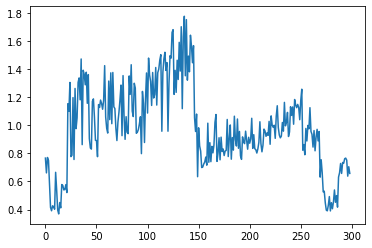

In [7]:
plt.plot(torch.exp(model.E_scale).cpu().detach().numpy())

RuntimeError: operation does not have an identity.

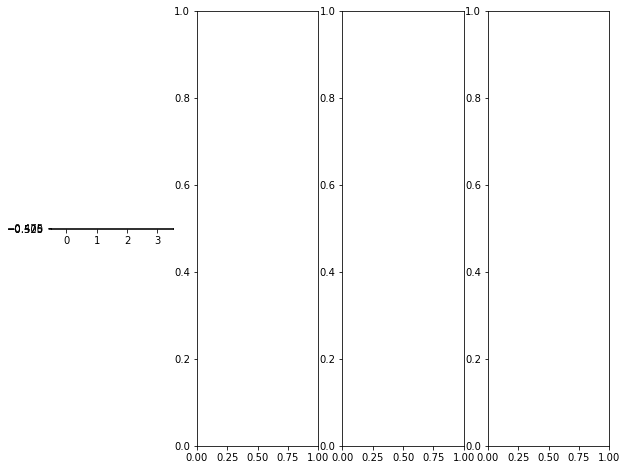

In [8]:
fig, axs = plt.subplots(ncols=4, figsize = (10,8))
start_idx = 880

for i in range(4):
    axs[i].imshow(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i].cpu().detach().numpy().T)
    print(torch.min(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i]).item(),
          torch.max(model.C_syn_e_raw[:,start_idx+60*i:start_idx+60+60*i]).item())

In [9]:
C_syn_plot = np.zeros((E_no))

for e in range(E_no):
    C_syn_plot[e] = torch.argmax(test_C_syn_e[:,e])

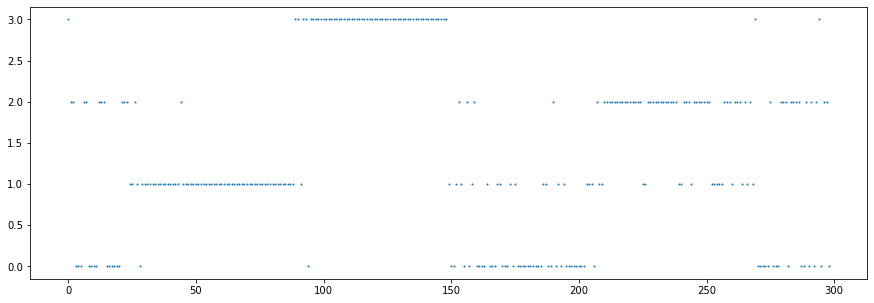

In [10]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), C_syn_plot, s=1)

ValueError: x and y must be the same size

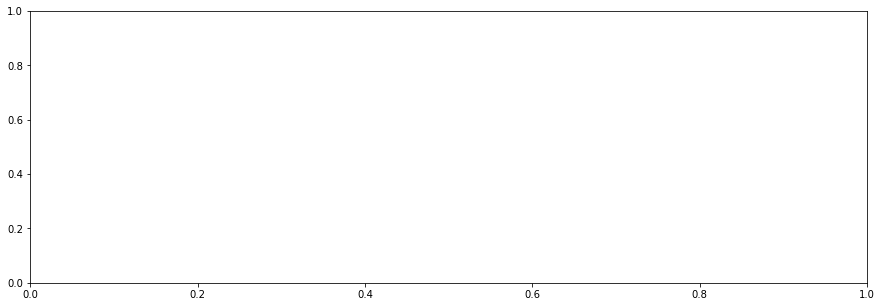

In [11]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(240), C_syn_plot[880:1120], s=1)

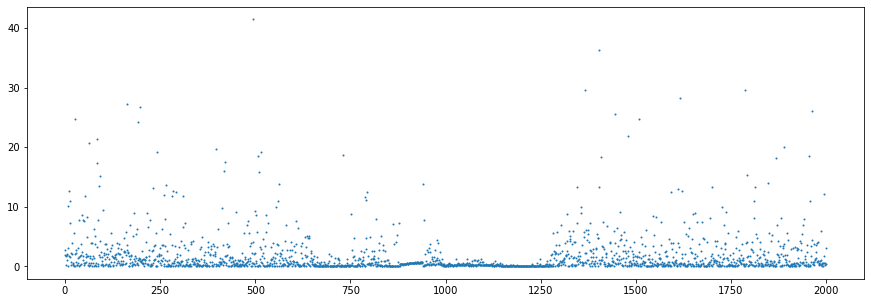

In [10]:
plt.figure(figsize = (15,5))
plt.scatter(np.arange(E_no), np.exp(model.E_scale.cpu().detach().numpy()), s=1)

In [8]:
E_scale = model.E_scale.cpu().detach().numpy()
C_syn_e_raw = model.C_syn_e_raw.cpu().detach().numpy()

In [9]:
#np.savez("/media/hdd01/sklee/CA1_clust4-60/clust/pretrain_glm_s5_h2.npz",
        E_scale=E_scale,
        C_syn_e_raw=C_syn_e_raw)